# Damped Harmonic Oscillator fit

Here, we will model the dynamic structure factor data from Bill Bement's videos using a *damped harmonic oscillator (DHO) model*, mostly because I'm not sure of what other models exist, so it's a good place to start. The DHO model is as follows:

$$ \frac{S(q,\omega)}{S(q)} = I_0(q) \frac{\frac{1}{2} \Gamma_0(q)}{\omega^2 + (\Gamma_0(q)/2)^2} + I(q) \frac{\Omega(q) \Gamma^2(q)}{(\omega^2 - \Omega^2(q))^2 + \omega^2 \Gamma^2(q)} $$

The first term is the "Rayleigh peak", which quantifies self-diffusivity (this would be the only term present for freely diffusing particles) with:
* amplitude $I_0(q)$
* width $\Gamma_0(q)$

The second term is the "Brillouin peak", which reflects an elastic response to the density fluctuations, with:
* amplitude $I(q)$
* width $\Gamma(q)$
* peak position $\Omega(q)$

This function is defined with `dynamicStructureFactor.sqw.dhoModel`

### Method
Get the normalized dynamic structure factor, $S(q,\omega)/S(q)$, and for each $q$ value, fit the DHO model to the resulting curve (which is a function of $\omega$). We will also cut out the zero frequency (DC) component for the fit. Obtain a goodness of fit ($R^2$) value for each fit along $q$, and see how all the functions of $q$ given above evolve

In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image',cmap='inferno')
%matplotlib notebook

import scipy.optimize as optimization
import scipy as sci
import seaborn as sns

# Custom modules
import dynamicstructurefactor.sqw as sqw
import pytools.mathtools as mts

# output_notebook()
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
movieNames = ['AVG_071714ect2-001.xml - C=0.tif', 'AVG_071714ect2-001.xml - C=1.tif',
              'AVG_071714ect2-009.xml - C=0.tif', 'AVG_071714ect2-009.xml - C=1.tif',
              'AVG_071714ect2-012.xml - C=0.tif', 'AVG_071714ect2-012.xml - C=1.tif',
              'AVG_071714ect2-014.xml - C=0.tif', 'AVG_071714ect2-014.xml - C=1.tif',
              'AVG_071714ect2-026.xml - C=0.tif', 'AVG_071714ect2-026.xml - C=1.tif',
              'AVG_071714ect2-027.xml - C=0.tif', 'AVG_071714ect2-027.xml - C=1.tif',
              'AVG_C1-071714ect2-013.tif', 'AVG_C2-071714ect2-013.tif',
              'AVG_C1-eaect1-005.tif', 'AVG_C2-eaect1-005.tif',
              'AVG_C1-eaect1-010.tif', 'AVG_C2-eaect1-010.tif',
              'AVG_C1-ect2-004.tif', 'AVG_C2-ect2-004.tif',
              'AVG_eaect1-007.xml - C=0.tif', 'AVG_eaect1-007.xml - C=1.tif']

woundList = np.array([0,0,
                      1,1,
                      0,0,
                      0,0,
                      1,1,
                      1,1,
                      0,0,
                      0,0,
                      1,1,
                      1,1,
                      1,1])

maxQList = 2*np.pi /np.array([0.1922, 0.1922,
                     0.1922, 0.1922,
                     0.1538, 0.1538,
                     0.3434, 0.3434,
                     0.3808, 0.3808,
                     0.3808, 0.3808,
                     0.1922, 0.1922,
                     0.1922, 0.1922,
                     0.3232, 0.3232,
                     0.1922, 0.1922,
                     0.3232, 0.3232])

In [3]:
n = 4

if ~woundList[n]:
    normedSQW = np.loadtxt(os.path.join(movieNames[n], 'normedSQW.txt'), skiprows=1)
    qArr = np.loadtxt(os.path.join(movieNames[n], 'qArray.txt'), skiprows=1)
    wArr = np.loadtxt(os.path.join(movieNames[n], 'wArray.txt'), skiprows=1)
    dynStructureFactor = np.loadtxt(os.path.join(movieNames[n], 'sqw.txt'), skiprows=1)

movieNames[n]

'AVG_071714ect2-012.xml - C=0.tif'

In [4]:
maxQList[n]

40.852960384782747

In [5]:
sofq = sci.integrate.trapz(dynStructureFactor, wArr, axis=0)

In [6]:
fig = plt.figure()
xticks = qArr[::50]
yticks = wArr[::20]

ax = sns.heatmap(np.squeeze(normedSQW[np.where(wArr),:]), robust=True, cbar=True, cbar_kws={'extend': 'max'},
            cmap='magma', xticklabels=50, yticklabels=20)

plt.yticks(rotation=0)
#fig.savefig('fullSQW.tif', format='tif')

<IPython.core.display.Javascript object>

(array([ 13.5,  33.5,  53.5,  73.5,  93.5]),
 <a list of 5 Text yticklabel objects>)

Now perform the fitting over each $q$ slice of $S(q,\omega)/S(q)$ and get the fitted parameters as a function of $q$. A reminder of which parameters are what:

`sqw.dhoModel(w, Gamma0, I0, Gamma, I, Omega)`

Note to take out the DC component of the signal

In [7]:
# acIndex = np.where(wArr)
# x0 = np.zeros(5)

# Initialize arrays for parameters
Gamma0 = np.zeros(qArr.size)
I0 = np.zeros(qArr.size)
Gamma = np.zeros(qArr.size)
I = np.zeros(qArr.size)
Omega = np.zeros(qArr.size)
r2 = np.zeros(qArr.size)

gamma0Init = np.ones(qArr.size-1)#qArr[np.where(qArr)]
i0Init = np.ones(qArr.size-1)*1
gammaInit = qArr[np.where(qArr)]**2 / sofq[np.where(qArr)]
iInit = np.ones(qArr.size-1)*2
omegaInit = np.ones(qArr.size-1)*5

initialGuesses = np.vstack((gamma0Init, i0Init, gammaInit, iInit, omegaInit))
xdata = wArr[acIndex]

for ii in range(1,qArr.size):
    x0 = initialGuesses[:,ii]
    
    # squeeze out extra dimension from slicing the matrix
    ydata = np.squeeze(normedSQW[acIndex, ii])
    optParams, covariance = optimization.curve_fit(sqw.dhoModel, xdata, ydata, x0, maxfev=2000)

    fittedData = sqw.dhoModel(xdata, *optParams)
    
    r2[ii] = mts.rsquared(fittedData, ydata)
    [Gamma0[ii], I0[ii], Gamma[ii], I[ii], Omega[ii]] = optParams
    print(str(ii))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

In [8]:
ii

17

<IPython.core.display.Javascript object>


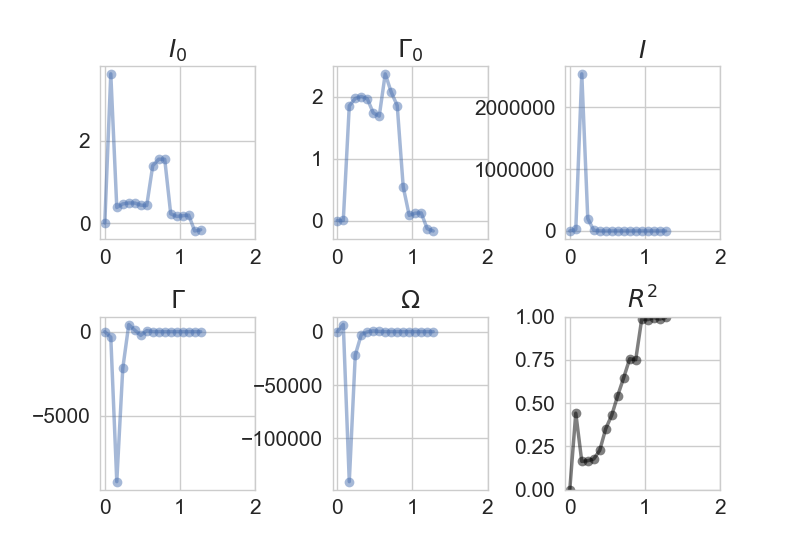

In [9]:
fig, ax = plt.subplots(2,3)#, gridspec_kw={'height_ratios':[4,1]}, sharex=True)


ax[0,0].plot(qArr[:ii], I0[:ii],     '-o', alpha = 0.5, label = '$I_0$'), ax[0,0].set_title('$I_0$'), ax[0,0]. set_xticks([0,1,2])
ax[0,1].plot(qArr[:ii], Gamma0[:ii], '-o', alpha = 0.5, label = '$\Gamma_0$'), ax[0,1].set_title('$\Gamma_0$'), ax[0,1]. set_xticks([0,1,2])
ax[0,2].plot(qArr[:ii], I[:ii],      '-o', alpha = 0.5, label = '$I$'), ax[0,2].set_title('$I$'), ax[0,2]. set_xticks([0,1,2])
ax[1,0].plot(qArr[:ii], Gamma[:ii],  '-o', alpha = 0.5, label = '$ \Gamma $'), ax[1,0].set_title('$\Gamma$'), ax[1,0]. set_xticks([0,1,2])
ax[1,1].plot(qArr[:ii], Omega[:ii],  '-o', alpha = 0.5, label = '$\Omega$'), ax[1,1].set_title('$\Omega$'), ax[1,1]. set_xticks([0,1,2])
ax[1,2].plot(qArr[:ii], r2[:ii], 'k-o', alpha = 0.5, label = '$R^2$'), ax[1,2].set_title('$R^2$'), ax[1,2]. set_xticks([0,1,2])
ax[1,2].set_ylim([0,1])

fig.subplots_adjust(wspace=0.5, hspace = 0.45)

fig.savefig('angelini_dhoFitParams.tif', format='tif')
fig.savefig('angelini_dhoFitParams.eps', format='eps')

<IPython.core.display.Javascript object>


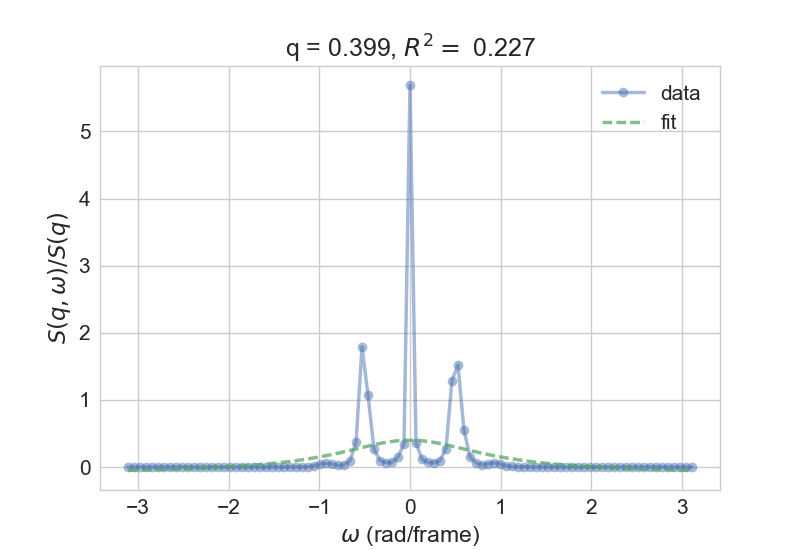

In [26]:
fig, ax = plt.subplots()
n = 5

fittedData = sqw.dhoModel(xdata, Gamma0[n], I0[n], Gamma[n], I[n], Omega[n])

ax.plot(wArr, normedSQW[:,n].T, '-o', alpha = 0.5, label = 'data')
ax.plot(xdata, fittedData, '--', alpha = 0.75, label = 'fit')
ax.set_xlabel('$\omega$ (rad/frame)')
ax.set_ylabel('$S(q,\omega)/S(q)$')
ax.set_title('q = {:1.3f}, $R^2 =$ {:1.3f}'.format(qArr[n], r2[n]))
plt.legend()

fig.savefig('earlyQFit.tif', format='tif')
fig.savefig('earlyQFit.eps', format='eps')

<IPython.core.display.Javascript object>


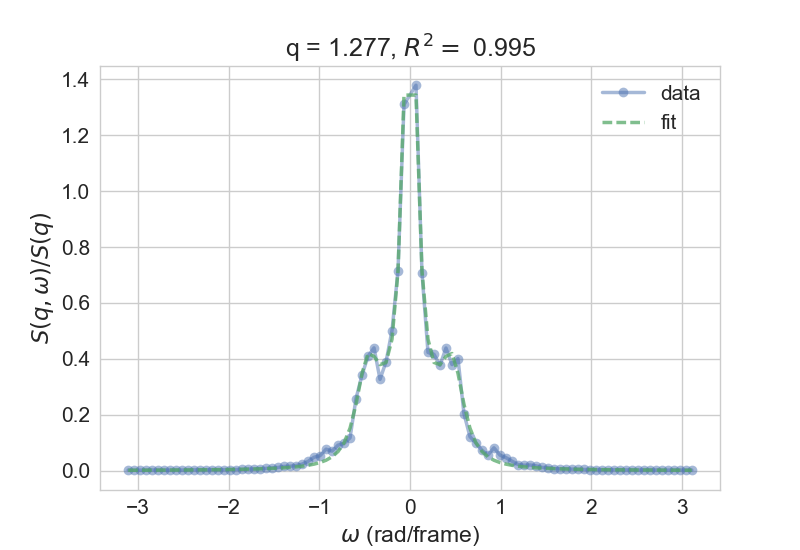

In [25]:
fig, ax = plt.subplots()
n = ii-1

fittedData = sqw.dhoModel(xdata, Gamma0[n], I0[n], Gamma[n], I[n], Omega[n])

ax.plot(xdata, normedSQW[np.where(wArr),n].T, '-o', alpha = 0.5, label = 'data')
ax.plot(xdata, fittedData, '--', alpha = 0.75, label = 'fit')
ax.set_xlabel('$\omega$ (rad/frame)')
ax.set_ylabel('$S(q,\omega)/S(q)$')
ax.set_title('q = {:1.3f}, $R^2 =$ {:1.3f}'.format(qArr[n], r2[n]))
plt.legend()

fig.savefig('lateQFit.tif', format='tif')
fig.savefig('lateQFit.eps', format='eps')